# CNN model optimised with Optuna and Transfer learning
- Setting up PyTorch model architecture with ResNet18/MobileNetV2 backbone
- Optimizing hyperparameters using Optuna 20 trials
- Training final model with most optimal hyperparameters

In [6]:
import os
import json
import time
import copy
import random
import numpy as np
import pandas as pd
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


In [7]:
projectRoot = Path().resolve().parent
outputRoot = projectRoot / "ModifiedDataset"

trainImagePath = outputRoot / "train" / "images"
trainLabelPath = outputRoot / "train" / "labels"
testImagePath = outputRoot / "test" / "images"
testLabelPath = outputRoot / "test" / "labels"
augImagePath = outputRoot / "AugmentedData" / "images"
augLabelPath = outputRoot / "AugmentedData" / "labels"

modelsDir = outputRoot / "models"
modelsDir.mkdir(parents=True, exist_ok=True)

with open(outputRoot / "kfold_splits.json", "r") as f:
    kfold_splits = json.load(f)

def load_dataset(image_dir, label_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpeg', '.jpg', '.png'))])
    paths, labels = [], []
    for fname in image_files:
        paths.append(os.path.join(image_dir, fname))
        with open(os.path.join(label_dir, fname.replace('.jpeg', '.txt'))) as f:
            labels.append(int(f.read().strip()))
    return paths, np.array(labels)

train_image_paths, train_labels = load_dataset(trainImagePath, trainLabelPath)
test_image_paths, test_labels = load_dataset(testImagePath, testLabelPath)
aug_image_paths, aug_labels = load_dataset(augImagePath, augLabelPath)

all_train_image_paths = train_image_paths + aug_image_paths
all_train_labels = np.concatenate([train_labels, aug_labels])


In [8]:
def get_transforms(augment=False):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])

def create_dataset(image_paths, labels, transform):
    class CustomDataset(Dataset):
        def __init__(self, image_paths, labels, transform):
            self.image_paths = image_paths
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img = cv2.imread(self.image_paths[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.transform(img)
            return img, self.labels[idx]
    return CustomDataset(image_paths, labels, transform)


In [9]:
def build_model(backbone='resnet18', pretrained=True, num_classes=3):
    if backbone == 'resnet18':
        base = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        features = base.fc.in_features
        base = nn.Sequential(*list(base.children())[:-1])
    elif backbone == 'mobilenet_v2':
        base = models.mobilenet_v2(weights='IMAGENET1K_V1' if pretrained else None)
        features = base.classifier[1].in_features
        base = nn.Sequential(base.features, nn.AdaptiveAvgPool2d(1))
    else:
        raise ValueError("Unsupported backbone")

    model = nn.Sequential(
        base,
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model.to(device)


In [10]:
def freeze_model(model, freeze_ratio=0.7):
    all_params = list(model[0].parameters())
    cut = int(len(all_params) * freeze_ratio)
    for i, param in enumerate(all_params):
        param.requires_grad = i >= cut
    return model

def calculate_weights(labels):
    count = np.bincount(labels)
    total = len(labels)
    return torch.tensor(total / (len(count) * count), dtype=torch.float32).to(device)


In [11]:
def train_one_epoch(model, loader, criterion, optimizer, scheduler=None):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate_model(model, loader, criterion):
    model.eval()
    loss, preds, targets = 0, [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss += criterion(out, y).item() * x.size(0)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(y.cpu().numpy())
    acc = accuracy_score(targets, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted')
    return loss / len(loader.dataset), acc, prec, rec, f1, preds, targets


In [12]:
#func to perform kfold cross validation
def kfold_cross_validation(model_fn, train_image_paths, train_labels, 
                          kfold_splits, batch_size, num_epochs, 
                          learning_rate, weight_decay, class_weights=None,
                          scheduler_type='step', early_stopping_patience=5,
                          freeze_ratio=0.7):
    
    all_metrics = {}
    fold_accuracies = []
    all_val_preds = []
    all_val_targets = []
    
    for fold_idx in kfold_splits:
        print(f"\n#### Starting Fold {fold_idx} ####")
        
        # get train/val split for this fold
        train_indices = kfold_splits[fold_idx]['train']
        val_indices = kfold_splits[fold_idx]['val']
        
        # get train/val data
        fold_train_paths = [train_image_paths[i] for i in train_indices]
        fold_train_labels = train_labels[train_indices]
        fold_val_paths = [train_image_paths[i] for i in val_indices]
        fold_val_labels = train_labels[val_indices]
        
        print(f"Training on {len(fold_train_paths)} samples, validating on {len(fold_val_paths)} samples")
        print(f"Training class distribution: {np.bincount(fold_train_labels)}")
        print(f"Validation class distribution: {np.bincount(fold_val_labels)}")
        
        # create datasets
        train_transform = get_transforms(augment=False)
        val_transform = get_transforms(augment=False)
    
        
        train_dataset = FaceMaskDataset(fold_train_paths, fold_train_labels, transform=train_transform)
        val_dataset = FaceMaskDataset(fold_val_paths, fold_val_labels, transform=val_transform)
        
        # create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                              num_workers=4, pin_memory=True)
        
        # create model
        model = model_fn()
        model = freeze_layers(model, freeze_ratio=freeze_ratio)
        model = model.to(device)
        
        # create loss function
        if class_weights is not None:
            criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            criterion = nn.CrossEntropyLoss()
        
        # create optimizer
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # create learning rate scheduler
        scheduler = None
        if scheduler_type == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        elif scheduler_type == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        elif scheduler_type == 'onecycle':
            steps_per_epoch = len(train_loader)
            scheduler = optim.lr_scheduler.OneCycleLR(
                optimizer, 
                max_lr=learning_rate,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs
            )
        elif scheduler_type == 'reduce_on_plateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        
        # training loop
        best_val_loss = float('inf')
        best_model_weights = None
        early_stopping_counter = 0
        fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # training
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, 
                                             scheduler if scheduler_type == 'onecycle' else None)
            
            # validate
            val_loss, val_acc, val_precision, val_recall, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
            
            # update the scheduler
            if scheduler is not None:
                if scheduler_type == 'reduce_on_plateau':
                    scheduler.step(val_loss)
                elif scheduler_type != 'onecycle':  # OneCycleLR is already updated in train_epoch
                    scheduler.step()
            
            # track metrics
            fold_history['train_loss'].append(train_loss)
            fold_history['train_acc'].append(train_acc)
            fold_history['val_loss'].append(val_loss)
            fold_history['val_acc'].append(val_acc)
            
            # print stats
            epoch_time = time.time() - start_time
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                  f"Val F1: {val_f1:.4f} | Time: {epoch_time:.2f}s")
            
            # check if this is best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_weights = copy.deepcopy(model.state_dict())
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            
            #early stopping
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        #load best model weights
        model.load_state_dict(best_model_weights)
        
        # final evaluation on validation set
        val_loss, val_acc, val_precision, val_recall, val_f1, val_preds, val_targets = evaluate(
            model, val_loader, criterion, device)
        
        # store predictions for combined evaluation
        all_val_preds.extend(val_preds)
        all_val_targets.extend(val_targets)
        
        # print final metrics
        print(f"\nFold {fold_idx} | Val Accuracy: {val_acc:.4f} | Precision: {val_precision:.4f} | "
              f"Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(val_targets, val_preds, target_names=['No Mask', 'Mask', 'Improper Mask']))
        
        # store metrics
        all_metrics[fold_idx] = {
            'val_accuracy': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'history': fold_history
        }
        
        fold_accuracies.append(val_acc)
        
        # free up GPU memory to avoid crashing
        del model, train_loader, val_loader, train_dataset, val_dataset
        torch.cuda.empty_cache()
    
    # calculate avg metrics
    avg_accuracy = np.mean(fold_accuracies)
    print(f"\nAverage validation accuracy across all folds: {avg_accuracy:.4f}")
    
    # Ppint overall metrics
    overall_report = classification_report(all_val_targets, all_val_preds, 
                                         target_names=['No Mask', 'Mask', 'Improper Mask'])
    print("\nOverall Classification Report:")
    print(overall_report)
    
    all_metrics['average'] = {
        'val_accuracy': avg_accuracy, 
        'overall_report': overall_report
    }
    return all_metrics


In [13]:
def train_final_model(params, all_train_image_paths, all_train_labels, test_image_paths, test_labels):
    indices = list(range(len(all_train_image_paths)))
    np.random.shuffle(indices)
    split = int(0.1 * len(indices))
    train_idx, val_idx = indices[split:], indices[:split]

    X_train = [all_train_image_paths[i] for i in train_idx]
    y_train = all_train_labels[train_idx]
    X_val = [all_train_image_paths[i] for i in val_idx]
    y_val = all_train_labels[val_idx]

    train_ds = create_dataset(X_train, y_train, get_transforms(augment=True))
    val_ds = create_dataset(X_val, y_val, get_transforms(augment=False))
    test_ds = create_dataset(test_image_paths, test_labels, get_transforms(augment=False))

    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'], shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False, num_workers=4)

    model = MaskDetectionCNN(backbone=params['backbone'], pretrained=True)
    model = freeze_layers(model, params['freeze_ratio']).to(device)

    criterion = nn.CrossEntropyLoss(weight=calculate_class_weights(all_train_labels)
                                    if params['use_class_weights'] else None)
    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

    if params['scheduler_type'] == 'onecycle':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=params['learning_rate'],
                                                  steps_per_epoch=len(train_loader), epochs=30)
    elif params['scheduler_type'] == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif params['scheduler_type'] == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    else:
        scheduler = None

    best_weights = None
    best_loss = float('inf')
    patience = 0

    for epoch in range(30):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer,
                                                scheduler if params['scheduler_type'] == 'onecycle' else None)
        val_loss, val_acc, *_ = evaluate_model(model, val_loader, criterion)

        if params['scheduler_type'] == 'step' and scheduler:
            scheduler.step()

        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {time.time()-t0:.2f}s")

        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1
            if patience >= 5:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), f"{modelsDir}/cnn_final_model.pt")

    _, acc, prec, rec, f1, preds, targets = evaluate_model(model, test_loader, criterion)
    cm = confusion_matrix(targets, preds)

    return model, {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'confusion_matrix': cm,
        'classification_report': classification_report(targets, preds, target_names=['No Mask', 'Mask', 'Improper Mask'])
    }


In [15]:
def optimize_hyperparameters(train_image_paths, train_labels, kfold_splits, n_trials=20):
    def objective(trial):
        backbone = trial.suggest_categorical('backbone', ['resnet18', 'mobilenet_v2'])
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        use_class_weights = trial.suggest_categorical('use_class_weights', [True, False])
        scheduler_type = trial.suggest_categorical('scheduler_type', ['step', 'cosine', 'onecycle', 'reduce_on_plateau'])
        freeze_ratio = trial.suggest_float('freeze_ratio', 0.5, 0.9)

        class_weights = calculate_class_weights(train_labels) if use_class_weights else None

        def create_model():
            return MaskDetectionCNN(backbone=backbone, pretrained=True)

        metrics = kfold_cross_validation(
            model_fn=create_model,
            train_image_paths=train_image_paths,
            train_labels=train_labels,
            kfold_splits=kfold_splits,
            batch_size=batch_size,
            num_epochs=5,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            class_weights=class_weights,
            scheduler_type=scheduler_type,
            early_stopping_patience=3,
            freeze_ratio=freeze_ratio
        )
        return metrics['average']['val_accuracy']

    pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=5)
    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", pruner=pruner, sampler=sampler)
    study.optimize(objective, n_trials=n_trials)

    print("Best trial:")
    print(f"  Value: {study.best_trial.value}")
    for key, val in study.best_trial.params.items():
        print(f"  {key}: {val}")
    return study.best_trial.params


In [16]:
# run optuna to get betst hyperparameters
params = optimize_hyperparameters(
    all_train_image_paths, 
    all_train_labels, 
    kfold_splits, 
    n_trials=20
)


[I 2025-04-12 17:39:07,958] A new study created in memory with name: no-name-c5af7dce-dedc-4244-b95f-0f07cbea66b3



--- Starting Fold 0 ---
Training on 3078 samples, validating on 770 samples
Training class distribution: [ 902 1552  624]
Validation class distribution: [226 388 156]
Epoch 1/5 | Train Loss: 1.1014 | Train Acc: 0.3304 | Val Loss: 0.9846 | Val Acc: 0.6247 | Val F1: 0.5924 | Time: 4.29s
Epoch 2/5 | Train Loss: 0.8438 | Train Acc: 0.6540 | Val Loss: 0.6844 | Val Acc: 0.7922 | Val F1: 0.7798 | Time: 4.22s
Epoch 3/5 | Train Loss: 0.6199 | Train Acc: 0.7710 | Val Loss: 0.5347 | Val Acc: 0.8312 | Val F1: 0.8249 | Time: 4.16s
Epoch 4/5 | Train Loss: 0.5267 | Train Acc: 0.8086 | Val Loss: 0.5033 | Val Acc: 0.8545 | Val F1: 0.8492 | Time: 4.17s
Epoch 5/5 | Train Loss: 0.4763 | Train Acc: 0.8330 | Val Loss: 0.4850 | Val Acc: 0.8519 | Val F1: 0.8468 | Time: 4.26s

Fold 0 | Val Accuracy: 0.8519 | Precision: 0.8567 | Recall: 0.8519 | F1: 0.8468

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.77      0.81      0.79       226
         Mask       0

[I 2025-04-12 17:41:00,442] Trial 0 finished with value: 0.850572002769662 and parameters: {'backbone': 'mobilenet_v2', 'batch_size': 16, 'learning_rate': 2.0511104188433963e-05, 'weight_decay': 1.3066739238053272e-05, 'use_class_weights': True, 'scheduler_type': 'onecycle', 'freeze_ratio': 0.5849356442713105}. Best is trial 0 with value: 0.850572002769662.



Fold 4 | Val Accuracy: 0.8388 | Precision: 0.8376 | Recall: 0.8388 | F1: 0.8370

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.77      0.76      0.77       225
         Mask       0.87      0.93      0.90       388
Improper Mask       0.85      0.74      0.79       156

     accuracy                           0.84       769
    macro avg       0.83      0.81      0.82       769
 weighted avg       0.84      0.84      0.84       769


Average validation accuracy across all folds: 0.8506

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.81      0.75      0.78      1128
         Mask       0.86      0.96      0.91      1940
Improper Mask       0.88      0.73      0.80       780

     accuracy                           0.85      3848
    macro avg       0.85      0.81      0.83      3848
 weighted avg       0.85      0.85      0.85      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:42:45,995] Trial 1 finished with value: 0.8505726782969957 and parameters: {'backbone': 'mobilenet_v2', 'batch_size': 32, 'learning_rate': 3.8234752246751835e-05, 'weight_decay': 0.00016738085788752134, 'use_class_weights': False, 'scheduler_type': 'onecycle', 'freeze_ratio': 0.7056937753654446}. Best is trial 1 with value: 0.8505726782969957.



Fold 4 | Val Accuracy: 0.8531 | Precision: 0.8518 | Recall: 0.8531 | F1: 0.8504

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.80      0.76      0.78       225
         Mask       0.87      0.95      0.91       388
Improper Mask       0.86      0.74      0.80       156

     accuracy                           0.85       769
    macro avg       0.85      0.82      0.83       769
 weighted avg       0.85      0.85      0.85       769


Average validation accuracy across all folds: 0.8506

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.81      0.75      0.78      1128
         Mask       0.87      0.96      0.91      1940
Improper Mask       0.87      0.71      0.79       780

     accuracy                           0.85      3848
    macro avg       0.85      0.81      0.82      3848
 weighted avg       0.85      0.85      0.85      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:44:53,724] Trial 2 finished with value: 0.9350314964619256 and parameters: {'backbone': 'resnet18', 'batch_size': 16, 'learning_rate': 0.000790261954970823, 'weight_decay': 0.0008536189862866829, 'use_class_weights': True, 'scheduler_type': 'cosine', 'freeze_ratio': 0.6980707640445081}. Best is trial 2 with value: 0.9350314964619256.



Fold 4 | Val Accuracy: 0.9350 | Precision: 0.9353 | Recall: 0.9350 | F1: 0.9351

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.90      0.91      0.90       225
         Mask       0.95      0.95      0.95       388
Improper Mask       0.96      0.94      0.95       156

     accuracy                           0.93       769
    macro avg       0.93      0.93      0.93       769
 weighted avg       0.94      0.93      0.94       769


Average validation accuracy across all folds: 0.9350

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.91      0.90      0.90      1128
         Mask       0.95      0.96      0.95      1940
Improper Mask       0.95      0.93      0.94       780

     accuracy                           0.94      3848
    macro avg       0.93      0.93      0.93      3848
 weighted avg       0.94      0.94      0.93      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:46:55,050] Trial 3 finished with value: 0.8724003174978469 and parameters: {'backbone': 'mobilenet_v2', 'batch_size': 32, 'learning_rate': 0.00010968217207529509, 'weight_decay': 0.00012399967836846095, 'use_class_weights': False, 'scheduler_type': 'cosine', 'freeze_ratio': 0.8687496940092467}. Best is trial 2 with value: 0.9350314964619256.



Fold 4 | Val Accuracy: 0.8687 | Precision: 0.8692 | Recall: 0.8687 | F1: 0.8674

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.81      0.81      0.81       225
         Mask       0.89      0.94      0.92       388
Improper Mask       0.90      0.76      0.83       156

     accuracy                           0.87       769
    macro avg       0.87      0.84      0.85       769
 weighted avg       0.87      0.87      0.87       769


Average validation accuracy across all folds: 0.8724

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.83      0.79      0.81      1128
         Mask       0.89      0.96      0.92      1940
Improper Mask       0.89      0.79      0.84       780

     accuracy                           0.87      3848
    macro avg       0.87      0.84      0.86      3848
 weighted avg       0.87      0.87      0.87      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:48:45,183] Trial 4 finished with value: 0.7804053164001148 and parameters: {'backbone': 'mobilenet_v2', 'batch_size': 64, 'learning_rate': 3.488976654890367e-05, 'weight_decay': 0.00045443839603360173, 'use_class_weights': True, 'scheduler_type': 'onecycle', 'freeze_ratio': 0.8947547746402069}. Best is trial 2 with value: 0.9350314964619256.



Fold 4 | Val Accuracy: 0.7776 | Precision: 0.7716 | Recall: 0.7776 | F1: 0.7697

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.74      0.58      0.65       225
         Mask       0.82      0.94      0.87       388
Improper Mask       0.70      0.67      0.69       156

     accuracy                           0.78       769
    macro avg       0.75      0.73      0.74       769
 weighted avg       0.77      0.78      0.77       769


Average validation accuracy across all folds: 0.7804

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.75      0.55      0.64      1128
         Mask       0.82      0.94      0.88      1940
Improper Mask       0.69      0.72      0.70       780

     accuracy                           0.78      3848
    macro avg       0.76      0.74      0.74      3848
 weighted avg       0.78      0.78      0.77      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:50:35,131] Trial 5 finished with value: 0.9417877830881732 and parameters: {'backbone': 'resnet18', 'batch_size': 32, 'learning_rate': 0.0002870875348195468, 'weight_decay': 0.000348771262454593, 'use_class_weights': False, 'scheduler_type': 'cosine', 'freeze_ratio': 0.5254233401144095}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.9389 | Precision: 0.9392 | Recall: 0.9389 | F1: 0.9390

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.90      0.92      0.91       225
         Mask       0.96      0.95      0.95       388
Improper Mask       0.95      0.94      0.94       156

     accuracy                           0.94       769
    macro avg       0.94      0.94      0.94       769
 weighted avg       0.94      0.94      0.94       769


Average validation accuracy across all folds: 0.9418

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.91      0.92      0.91      1128
         Mask       0.95      0.96      0.96      1940
Improper Mask       0.96      0.93      0.94       780

     accuracy                           0.94      3848
    macro avg       0.94      0.94      0.94      3848
 weighted avg       0.94      0.94      0.94      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:52:23,856] Trial 6 finished with value: 0.8900734635975208 and parameters: {'backbone': 'mobilenet_v2', 'batch_size': 64, 'learning_rate': 8.798929749689021e-05, 'weight_decay': 1.7345566642360933e-05, 'use_class_weights': False, 'scheduler_type': 'cosine', 'freeze_ratio': 0.6710164073434198}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.8843 | Precision: 0.8840 | Recall: 0.8843 | F1: 0.8839

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.83      0.83      0.83       225
         Mask       0.91      0.94      0.92       388
Improper Mask       0.89      0.83      0.86       156

     accuracy                           0.88       769
    macro avg       0.88      0.87      0.87       769
 weighted avg       0.88      0.88      0.88       769


Average validation accuracy across all folds: 0.8901

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.85      0.83      0.84      1128
         Mask       0.90      0.95      0.93      1940
Improper Mask       0.91      0.82      0.87       780

     accuracy                           0.89      3848
    macro avg       0.89      0.87      0.88      3848
 weighted avg       0.89      0.89      0.89      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:54:16,477] Trial 7 finished with value: 0.916061337881884 and parameters: {'backbone': 'mobilenet_v2', 'batch_size': 32, 'learning_rate': 0.0001040258761588385, 'weight_decay': 0.0006533305220227731, 'use_class_weights': False, 'scheduler_type': 'step', 'freeze_ratio': 0.5644885149016018}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.9194 | Precision: 0.9201 | Recall: 0.9194 | F1: 0.9185

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.91      0.85      0.88       225
         Mask       0.91      0.98      0.94       388
Improper Mask       0.95      0.87      0.91       156

     accuracy                           0.92       769
    macro avg       0.93      0.90      0.91       769
 weighted avg       0.92      0.92      0.92       769


Average validation accuracy across all folds: 0.9161

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.90      0.86      0.88      1128
         Mask       0.93      0.96      0.94      1940
Improper Mask       0.92      0.89      0.90       780

     accuracy                           0.92      3848
    macro avg       0.91      0.90      0.91      3848
 weighted avg       0.92      0.92      0.92      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:56:03,679] Trial 8 finished with value: 0.8723945755155118 and parameters: {'backbone': 'resnet18', 'batch_size': 32, 'learning_rate': 2.3612399244412595e-05, 'weight_decay': 0.0006097025297491432, 'use_class_weights': False, 'scheduler_type': 'step', 'freeze_ratio': 0.6708431154505026}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.8531 | Precision: 0.8526 | Recall: 0.8531 | F1: 0.8495

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.81      0.76      0.78       225
         Mask       0.87      0.96      0.91       388
Improper Mask       0.88      0.72      0.79       156

     accuracy                           0.85       769
    macro avg       0.85      0.81      0.83       769
 weighted avg       0.85      0.85      0.85       769


Average validation accuracy across all folds: 0.8724

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.83      0.79      0.81      1128
         Mask       0.88      0.96      0.92      1940
Improper Mask       0.90      0.76      0.82       780

     accuracy                           0.87      3848
    macro avg       0.87      0.84      0.85      3848
 weighted avg       0.87      0.87      0.87      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:57:54,308] Trial 9 finished with value: 0.7921017344164288 and parameters: {'backbone': 'mobilenet_v2', 'batch_size': 32, 'learning_rate': 2.781093697926551e-05, 'weight_decay': 1.736723715159314e-05, 'use_class_weights': False, 'scheduler_type': 'onecycle', 'freeze_ratio': 0.8887128330883842}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.7997 | Precision: 0.7972 | Recall: 0.7997 | F1: 0.7891

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.76      0.63      0.69       225
         Mask       0.81      0.98      0.89       388
Improper Mask       0.82      0.60      0.69       156

     accuracy                           0.80       769
    macro avg       0.80      0.73      0.75       769
 weighted avg       0.80      0.80      0.79       769


Average validation accuracy across all folds: 0.7921

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.74      0.61      0.67      1128
         Mask       0.81      0.98      0.89      1940
Improper Mask       0.81      0.59      0.68       780

     accuracy                           0.79      3848
    macro avg       0.79      0.73      0.74      3848
 weighted avg       0.79      0.79      0.78      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 17:59:58,763] Trial 10 finished with value: 0.9282762231266781 and parameters: {'backbone': 'resnet18', 'batch_size': 16, 'learning_rate': 0.0006746377252925518, 'weight_decay': 4.939713749567097e-05, 'use_class_weights': True, 'scheduler_type': 'reduce_on_plateau', 'freeze_ratio': 0.5060619611170866}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.9441 | Precision: 0.9441 | Recall: 0.9441 | F1: 0.9439

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.94      0.90      0.92       225
         Mask       0.96      0.97      0.96       388
Improper Mask       0.92      0.94      0.93       156

     accuracy                           0.94       769
    macro avg       0.94      0.94      0.94       769
 weighted avg       0.94      0.94      0.94       769


Average validation accuracy across all folds: 0.9283

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.90      0.89      0.90      1128
         Mask       0.95      0.96      0.95      1940
Improper Mask       0.91      0.92      0.91       780

     accuracy                           0.93      3848
    macro avg       0.92      0.92      0.92      3848
 weighted avg       0.93      0.93      0.93      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:01:59,645] Trial 11 finished with value: 0.918652660733285 and parameters: {'backbone': 'resnet18', 'batch_size': 16, 'learning_rate': 0.0008332334231893163, 'weight_decay': 0.0002733762389478881, 'use_class_weights': True, 'scheduler_type': 'cosine', 'freeze_ratio': 0.7822929774689608}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.9077 | Precision: 0.9072 | Recall: 0.9077 | F1: 0.9074

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.87      0.85      0.86       225
         Mask       0.93      0.95      0.94       388
Improper Mask       0.91      0.88      0.90       156

     accuracy                           0.91       769
    macro avg       0.90      0.90      0.90       769
 weighted avg       0.91      0.91      0.91       769


Average validation accuracy across all folds: 0.9187

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.88      0.87      0.88      1128
         Mask       0.93      0.96      0.94      1940
Improper Mask       0.93      0.89      0.91       780

     accuracy                           0.92      3848
    macro avg       0.92      0.91      0.91      3848
 weighted avg       0.92      0.92      0.92      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:03:59,762] Trial 12 finished with value: 0.9293128198199719 and parameters: {'backbone': 'resnet18', 'batch_size': 16, 'learning_rate': 0.0003067691543425867, 'weight_decay': 0.0009889552999047873, 'use_class_weights': True, 'scheduler_type': 'cosine', 'freeze_ratio': 0.7612012640576854}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.9129 | Precision: 0.9156 | Recall: 0.9129 | F1: 0.9136

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.84      0.91      0.87       225
         Mask       0.95      0.91      0.93       388
Improper Mask       0.94      0.93      0.93       156

     accuracy                           0.91       769
    macro avg       0.91      0.92      0.91       769
 weighted avg       0.92      0.91      0.91       769


Average validation accuracy across all folds: 0.9293

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.90      0.90      0.90      1128
         Mask       0.94      0.95      0.95      1940
Improper Mask       0.95      0.92      0.93       780

     accuracy                           0.93      3848
    macro avg       0.93      0.92      0.93      3848
 weighted avg       0.93      0.93      0.93      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:06:01,738] Trial 13 finished with value: 0.9394447165318427 and parameters: {'backbone': 'resnet18', 'batch_size': 16, 'learning_rate': 0.00029606940211992025, 'weight_decay': 0.0002806531832376586, 'use_class_weights': True, 'scheduler_type': 'cosine', 'freeze_ratio': 0.5908556046603515}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.9324 | Precision: 0.9323 | Recall: 0.9324 | F1: 0.9323

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.90      0.89      0.90       225
         Mask       0.94      0.94      0.94       388
Improper Mask       0.96      0.96      0.96       156

     accuracy                           0.93       769
    macro avg       0.93      0.93      0.93       769
 weighted avg       0.93      0.93      0.93       769


Average validation accuracy across all folds: 0.9394

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.90      0.92      0.91      1128
         Mask       0.95      0.96      0.95      1940
Improper Mask       0.98      0.92      0.95       780

     accuracy                           0.94      3848
    macro avg       0.94      0.93      0.94      3848
 weighted avg       0.94      0.94      0.94      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:07:46,179] Trial 14 finished with value: 0.9046324286896459 and parameters: {'backbone': 'resnet18', 'batch_size': 64, 'learning_rate': 0.00028961603572682067, 'weight_decay': 6.821018330793571e-05, 'use_class_weights': False, 'scheduler_type': 'reduce_on_plateau', 'freeze_ratio': 0.5805269296622017}. Best is trial 5 with value: 0.9417877830881732.



Fold 4 | Val Accuracy: 0.9220 | Precision: 0.9225 | Recall: 0.9220 | F1: 0.9222

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.87      0.89      0.88       225
         Mask       0.95      0.93      0.94       388
Improper Mask       0.92      0.94      0.93       156

     accuracy                           0.92       769
    macro avg       0.92      0.92      0.92       769
 weighted avg       0.92      0.92      0.92       769


Average validation accuracy across all folds: 0.9046

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.87      0.85      0.86      1128
         Mask       0.92      0.96      0.94      1940
Improper Mask       0.92      0.86      0.89       780

     accuracy                           0.90      3848
    macro avg       0.90      0.89      0.89      3848
 weighted avg       0.90      0.90      0.90      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:09:38,963] Trial 15 finished with value: 0.9449090571327243 and parameters: {'backbone': 'resnet18', 'batch_size': 32, 'learning_rate': 0.0003131594569593978, 'weight_decay': 0.000299450113017805, 'use_class_weights': True, 'scheduler_type': 'cosine', 'freeze_ratio': 0.5087792159637191}. Best is trial 15 with value: 0.9449090571327243.



Fold 4 | Val Accuracy: 0.9454 | Precision: 0.9453 | Recall: 0.9454 | F1: 0.9454

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.92      0.92      0.92       225
         Mask       0.95      0.96      0.95       388
Improper Mask       0.96      0.96      0.96       156

     accuracy                           0.95       769
    macro avg       0.94      0.94      0.94       769
 weighted avg       0.95      0.95      0.95       769


Average validation accuracy across all folds: 0.9449

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.91      0.94      0.92      1128
         Mask       0.96      0.95      0.96      1940
Improper Mask       0.96      0.95      0.95       780

     accuracy                           0.94      3848
    macro avg       0.94      0.94      0.94      3848
 weighted avg       0.95      0.94      0.95      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:11:31,361] Trial 16 finished with value: 0.9360704575008867 and parameters: {'backbone': 'resnet18', 'batch_size': 32, 'learning_rate': 0.00017273208663745886, 'weight_decay': 0.00030060949994479473, 'use_class_weights': False, 'scheduler_type': 'cosine', 'freeze_ratio': 0.5043956756975085}. Best is trial 15 with value: 0.9449090571327243.



Fold 4 | Val Accuracy: 0.9311 | Precision: 0.9309 | Recall: 0.9311 | F1: 0.9309

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.90      0.88      0.89       225
         Mask       0.94      0.95      0.95       388
Improper Mask       0.95      0.94      0.95       156

     accuracy                           0.93       769
    macro avg       0.93      0.93      0.93       769
 weighted avg       0.93      0.93      0.93       769


Average validation accuracy across all folds: 0.9361

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.91      0.91      0.91      1128
         Mask       0.94      0.96      0.95      1940
Improper Mask       0.96      0.91      0.93       780

     accuracy                           0.94      3848
    macro avg       0.94      0.93      0.93      3848
 weighted avg       0.94      0.94      0.94      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:13:24,263] Trial 17 finished with value: 0.945942951716684 and parameters: {'backbone': 'resnet18', 'batch_size': 32, 'learning_rate': 0.00047727527324339177, 'weight_decay': 0.00016745238338472984, 'use_class_weights': True, 'scheduler_type': 'cosine', 'freeze_ratio': 0.539003338255835}. Best is trial 17 with value: 0.945942951716684.



Fold 4 | Val Accuracy: 0.9415 | Precision: 0.9417 | Recall: 0.9415 | F1: 0.9413

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.91      0.90      0.91       225
         Mask       0.96      0.94      0.95       388
Improper Mask       0.93      0.99      0.96       156

     accuracy                           0.94       769
    macro avg       0.94      0.95      0.94       769
 weighted avg       0.94      0.94      0.94       769


Average validation accuracy across all folds: 0.9459

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.92      0.93      0.92      1128
         Mask       0.96      0.95      0.96      1940
Improper Mask       0.95      0.96      0.95       780

     accuracy                           0.95      3848
    macro avg       0.94      0.95      0.94      3848
 weighted avg       0.95      0.95      0.95      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:15:16,150] Trial 18 finished with value: 0.8292597909242904 and parameters: {'backbone': 'resnet18', 'batch_size': 32, 'learning_rate': 1.1560203927866087e-05, 'weight_decay': 3.7020344469812105e-05, 'use_class_weights': True, 'scheduler_type': 'reduce_on_plateau', 'freeze_ratio': 0.625383272989948}. Best is trial 17 with value: 0.945942951716684.



Fold 4 | Val Accuracy: 0.8114 | Precision: 0.8095 | Recall: 0.8114 | F1: 0.8020

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.81      0.58      0.68       225
         Mask       0.83      0.97      0.89       388
Improper Mask       0.77      0.74      0.75       156

     accuracy                           0.81       769
    macro avg       0.80      0.76      0.77       769
 weighted avg       0.81      0.81      0.80       769


Average validation accuracy across all folds: 0.8293

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.80      0.67      0.73      1128
         Mask       0.84      0.95      0.90      1940
Improper Mask       0.82      0.76      0.79       780

     accuracy                           0.83      3848
    macro avg       0.82      0.79      0.80      3848
 weighted avg       0.83      0.83      0.82      3848


--- Starting Fold 0 ---
Training

[I 2025-04-12 18:17:10,039] Trial 19 finished with value: 0.9368550824987756 and parameters: {'backbone': 'resnet18', 'batch_size': 32, 'learning_rate': 0.0004678958791799986, 'weight_decay': 0.00017905940393727802, 'use_class_weights': True, 'scheduler_type': 'step', 'freeze_ratio': 0.5446103783744939}. Best is trial 17 with value: 0.945942951716684.



Fold 4 | Val Accuracy: 0.9454 | Precision: 0.9452 | Recall: 0.9454 | F1: 0.9450

Classification Report:
               precision    recall  f1-score   support

      No Mask       0.93      0.89      0.91       225
         Mask       0.95      0.97      0.96       388
Improper Mask       0.95      0.97      0.96       156

     accuracy                           0.95       769
    macro avg       0.94      0.94      0.94       769
 weighted avg       0.95      0.95      0.95       769


Average validation accuracy across all folds: 0.9369

Overall Classification Report:
               precision    recall  f1-score   support

      No Mask       0.91      0.91      0.91      1128
         Mask       0.95      0.96      0.96      1940
Improper Mask       0.94      0.93      0.93       780

     accuracy                           0.94      3848
    macro avg       0.93      0.93      0.93      3848
 weighted avg       0.94      0.94      0.94      3848

Best trial:
  Value: 0.9459429517

In [17]:
# Recreate model builder using best params
def build_model_with_params():
    model = build_model(
        backbone=params['backbone'],
        pretrained=True
    )
    return freeze_model(model, freeze_ratio=params['freeze_ratio'])



# Class weights if needed
class_weights = calculate_class_weights(all_train_labels) if params['use_class_weights'] else None

# Perform k-fold validation using best params
metrics = kfold_cross_validation(
    model_fn=build_model_with_params,
    train_image_paths=all_train_image_paths,
    train_labels=all_train_labels,
    kfold_splits=kfold_splits,
    batch_size=params['batch_size'],
    num_epochs=30,
    learning_rate=params['learning_rate'],
    weight_decay=params['weight_decay'],
    class_weights=class_weights,
    scheduler_type=params['scheduler_type'],
    freeze_ratio=params['freeze_ratio']
)



--- Starting Fold 0 ---
Training on 3078 samples, validating on 770 samples
Training class distribution: [ 902 1552  624]
Validation class distribution: [226 388 156]
Epoch 1/30 | Train Loss: 0.5412 | Train Acc: 0.7846 | Val Loss: 0.2563 | Val Acc: 0.9091 | Val F1: 0.9097 | Time: 4.17s
Epoch 2/30 | Train Loss: 0.2314 | Train Acc: 0.9204 | Val Loss: 0.2397 | Val Acc: 0.9390 | Val F1: 0.9390 | Time: 4.19s
Epoch 3/30 | Train Loss: 0.1484 | Train Acc: 0.9431 | Val Loss: 0.2153 | Val Acc: 0.9286 | Val F1: 0.9289 | Time: 3.97s
Epoch 4/30 | Train Loss: 0.1040 | Train Acc: 0.9652 | Val Loss: 0.2871 | Val Acc: 0.9416 | Val F1: 0.9409 | Time: 4.09s
Epoch 5/30 | Train Loss: 0.0720 | Train Acc: 0.9747 | Val Loss: 0.2299 | Val Acc: 0.9610 | Val F1: 0.9610 | Time: 4.25s
Epoch 6/30 | Train Loss: 0.0718 | Train Acc: 0.9776 | Val Loss: 0.2481 | Val Acc: 0.9325 | Val F1: 0.9324 | Time: 5.45s
Epoch 7/30 | Train Loss: 0.0301 | Train Acc: 0.9916 | Val Loss: 0.2328 | Val Acc: 0.9416 | Val F1: 0.9417 | Time

In [18]:
# Train final model using full training set (with val split from it)
final_model, test_metrics = train_final_model(
    params,
    all_train_image_paths,
    all_train_labels,
    test_image_paths,
    test_labels
)


Epoch 01 | Train Loss: 0.5401 | Val Loss: 0.3934 | Time: 4.96s
Epoch 02 | Train Loss: 0.3178 | Val Loss: 0.2692 | Time: 4.96s
Epoch 03 | Train Loss: 0.2214 | Val Loss: 0.1739 | Time: 4.92s
Epoch 04 | Train Loss: 0.1697 | Val Loss: 0.1835 | Time: 5.05s
Epoch 05 | Train Loss: 0.1472 | Val Loss: 0.1597 | Time: 6.21s
Epoch 06 | Train Loss: 0.1079 | Val Loss: 0.1264 | Time: 4.97s
Epoch 07 | Train Loss: 0.1048 | Val Loss: 0.1114 | Time: 5.00s
Epoch 08 | Train Loss: 0.0909 | Val Loss: 0.1004 | Time: 4.96s
Epoch 09 | Train Loss: 0.0847 | Val Loss: 0.1380 | Time: 4.96s
Epoch 10 | Train Loss: 0.0942 | Val Loss: 0.1058 | Time: 4.98s
Epoch 11 | Train Loss: 0.0936 | Val Loss: 0.1514 | Time: 6.34s
Epoch 12 | Train Loss: 0.0565 | Val Loss: 0.0956 | Time: 5.09s
Epoch 13 | Train Loss: 0.0570 | Val Loss: 0.1452 | Time: 4.86s
Epoch 14 | Train Loss: 0.0626 | Val Loss: 0.1030 | Time: 5.04s
Epoch 15 | Train Loss: 0.0438 | Val Loss: 0.1104 | Time: 4.83s
Epoch 16 | Train Loss: 0.0557 | Val Loss: 0.0974 | Time


===== Final Test Results =====
Test Accuracy: 0.9148
Test Precision: 0.9262
Test Recall: 0.9148
Test F1 Score: 0.9186
               precision    recall  f1-score   support

      No Mask       0.68      0.88      0.77        51
         Mask       0.98      0.93      0.95       388
Improper Mask       0.57      0.63      0.60        19

     accuracy                           0.91       458
    macro avg       0.74      0.82      0.77       458
 weighted avg       0.93      0.91      0.92       458



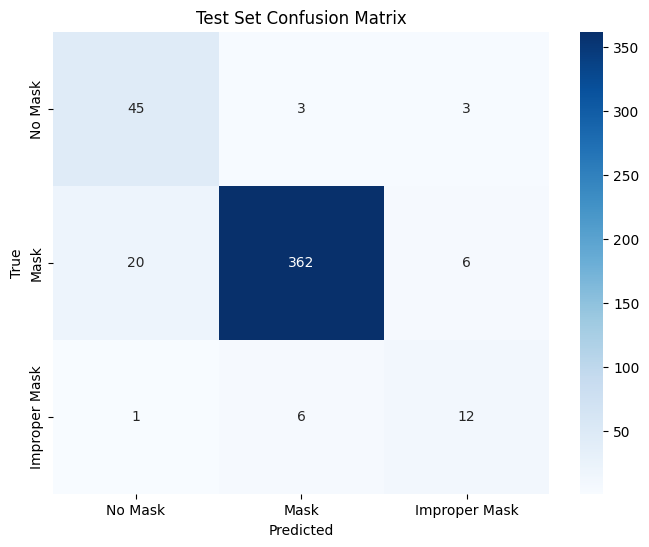

In [19]:
# Test metrics
print("\n##### Final Test Results #####")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1 Score: {test_metrics['f1']:.4f}")
print(test_metrics['classification_report'])

# Confusion matrix
cm = test_metrics['confusion_matrix']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Mask', 'Mask', 'Improper Mask'],
            yticklabels=['No Mask', 'Mask', 'Improper Mask'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Development of CNN Model: Major Findings

- **Transfer learning works effectively**: Pre-trained ResNet18 vastly outperforms MobileNetV2, suggesting architecture matters more than model size

- **Class imbalance** still remained an issue: but this was mititgated as much as possible by using augmentation, detection of the minority class ("Improper Mask 2") is still lagging behind, with only 63% recall compared to 93% for the majority class

- **Test Distribution Shift Impact**: The 3% gap between validation performance (94.6%) and test performance (91.5%) suggests that the model has trouble generalizing to the test set with a different distribution but this is quite a small diffrence so not much of an issue

- **Hyperparameter significance**: Learning rate ~0.0005 and freeze ratio ~0.54 were critical, freezing approximately half the pre-trained layers helped to provide the right balance between feature reuse and adaptation

- **Training efficiency**: Early stopping typically triggered between epochs 9-17, indicating diminishing returns beyond this point and potential for faster training cycles, and this was significantly helpful at reducing training time